# Лабораторная работа №6: "Анализ и прогнозирование временного ряда".

In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from gplearn.genetic import SymbolicRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Использован датасет, содержащий данные об изменении численности пассажиров авиаперелетов: https://www.kaggle.com/code/rakannimer/air-passenger-prediction/data

In [66]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [67]:
# Преобразование столбца даты в объект datetime и установка его в качестве индекса
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)
data.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [68]:
data.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Визуализация временного ряда

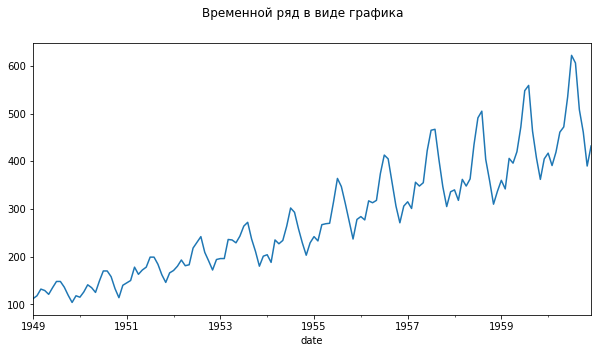

In [69]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

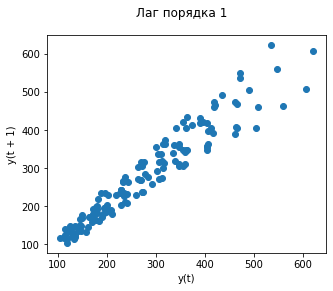

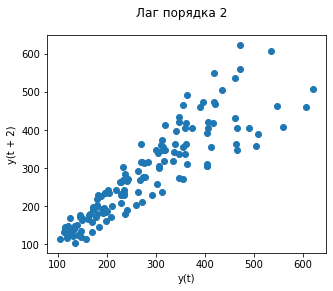

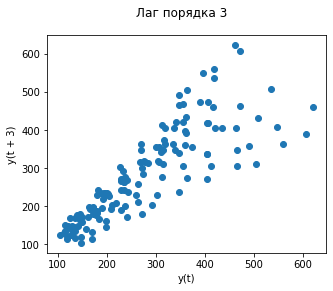

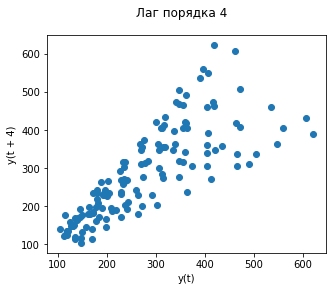

In [70]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    pyplot.show()

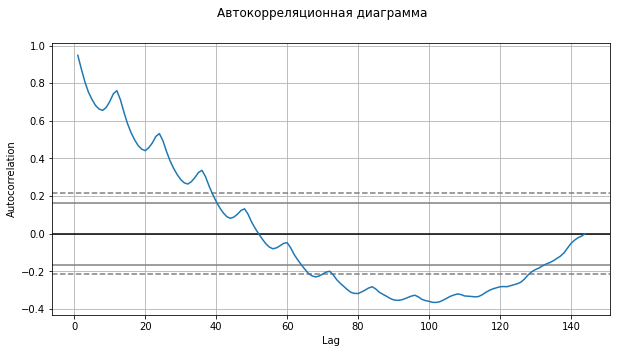

In [71]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

### Автокорреляционная функция

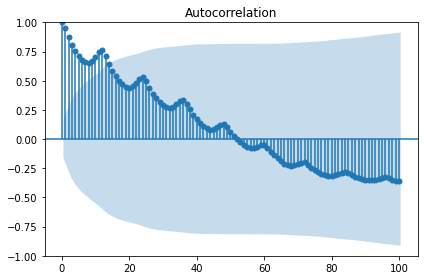

In [72]:
plot_acf(data, lags=100)
plt.tight_layout()

### Частичная автокорреляционная функция

/home/user/edu/6sem/ML/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


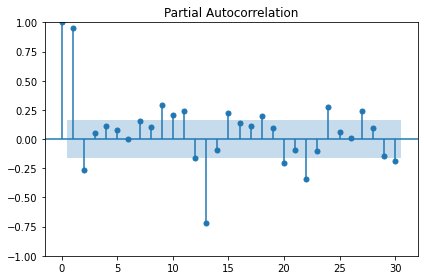

In [73]:
plot_pacf(data, lags=30)
plt.tight_layout()

### Декомпозиция временного ряда

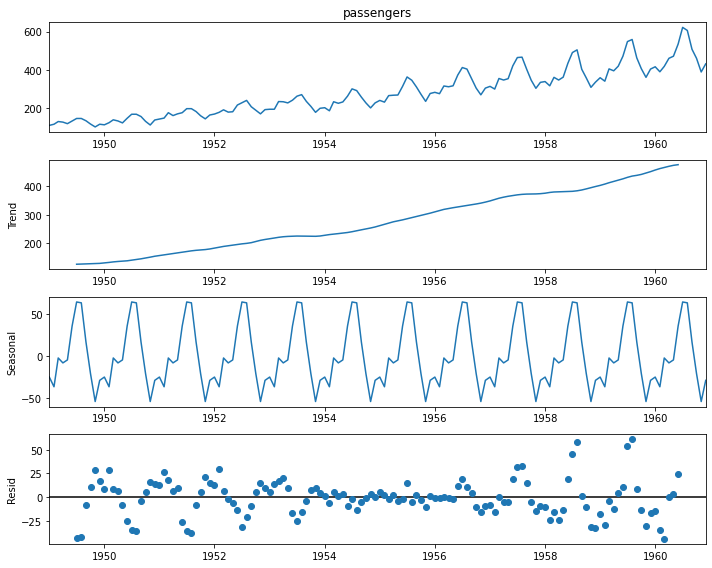

In [74]:
decomposed = seasonal_decompose(data['passengers'], model = 'add')
fig = decomposed.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

Наблюдается положительная динамика с 1949 по 1960 год.

## Разделение временного ряда на обучающую и тестовую выборку

In [75]:
data_2 = data.copy()
# Целочисленная метка шкалы времени
xnum = list(range(data_2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data_2['passengers'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]

## Прогнозирование временного ряда авторегрессионным методом (ARIMA)

In [76]:
# Параметры модели (p,d,q)
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [77]:
# Ошибка прогноза
np.mean(Y), error_arima

(280.2986111111111, 46.057002761125666)

In [78]:
# Записываем предсказания в DataFrame
data_2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)

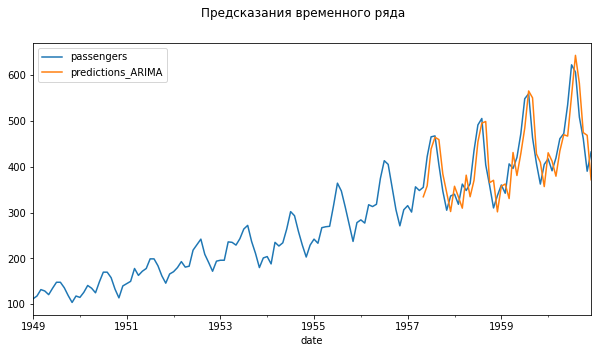

In [79]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data_2.plot(ax=ax, legend=True)
pyplot.show()

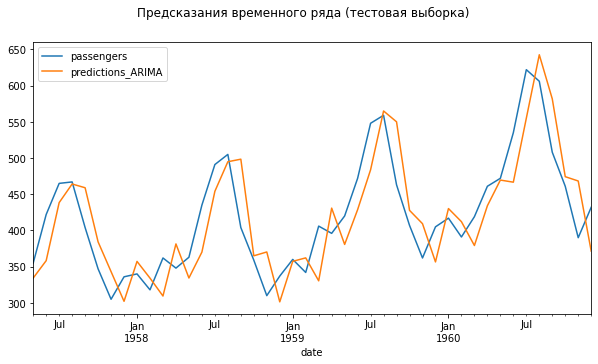

In [80]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

## Прогнозирование временного ряда методом символьной регресии

In [81]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
# SR = SymbolicRegressor(population_size=500, metric='mse',
#                                generations=70, stopping_criteria=0.01,
#                                init_depth=(4, 10), verbose=1, function_set=function_set,
#                                const_range=(-100, 100), random_state=0)
SR = SymbolicRegressor(function_set=function_set)

In [82]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

/usr/local/lib/python3.8/dist-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'sin'])

In [83]:
print(SR._program)

add(sin(mul(div(mul(sub(0.672, 0.421), sin(X0)), sin(add(0.115, 0.873))), add(sub(add(X0, -0.652), mul(X0, -0.166)), add(add(-0.244, X0), div(X0, X0))))), add(div(add(add(add(mul(add(div(sub(div(-0.249, X0), X0), sub(add(0.672, 0.421), add(X0, -0.608))), mul(sub(X0, X0), div(X0, -0.923))), add(X0, X0)), sub(div(sub(mul(X0, -0.594), sub(add(X0, X0), mul(add(-0.319, X0), sub(X0, X0)))), div(mul(X0, -0.275), add(X0, 0.895))), div(div(add(X0, X0), div(sub(div(-0.249, X0), X0), sub(div(-0.123, 0.135), add(X0, add(0.672, 0.421))))), add(add(-0.804, -0.383), div(-0.152, X0))))), add(sub(sin(0.218), sub(0.084, 0.394)), mul(0.836, X0))), add(div(X0, X0), mul(0.836, X0))), sub(sub(mul(sin(sub(X0, X0)), X0), sub(X0, X0)), mul(sin(-0.192), sub(X0, -0.107)))), sub(sub(div(X0, 0.668), mul(add(add(add(add(add(X0, X0), add(0.739, X0)), add(X0, 0.877)), mul(0.836, X0)), mul(0.836, X0)), sub(X0, X0))), sub(sub(sub(X0, X0), div(X0, div(sub(div(add(X0, X0), X0), X0), sub(div(-0.123, 0.135), add(X0, add(0.

In [84]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([331.07299995, 333.57199258, 337.05112752, 338.76662999,
       341.77953245, 344.78429121, 347.15649721, 349.77183919,
       352.76128217, 355.43663525])

In [85]:
# Записываем предсказания в DataFrame
data_2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_sr)

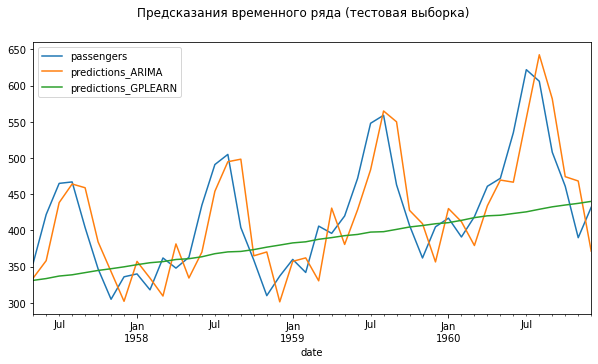

In [86]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [87]:
error_SR = mean_squared_error(test, y_sr, squared=False)

In [88]:
# Ошибка прогноза
np.mean(Y), error_SR

(280.2986111111111, 75.99504772367868)

## Качество прогноза моделей

In [89]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [90]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.6370252494109326
MSE: 46.057002761125666
MAE: 39.20362961620981

GPLEARN
R^2: 0.011775411773739308
MSE: 75.99504772367868
MAE: 55.12883922085609
